# 🧠 Motor Imagery Classifier — 2 Classes (Left vs Right)

**Goal:** Train and evaluate a binary MI classifier *(left-hand vs right-hand imagery)*.

---

## 🔁 Unit of Generalization

- **Unseen runs (within-subject):**  
  - Split **by run** *inside each subject*.  
  - Train on some runs, **test on held-out runs** of the **same** subject.

- **Unseen subjects (LOSO):**  
  - Split **by subject** using `GroupKFold` / `LeaveOneGroupOut`.  
  - Train on all but one subject, **test on the held-out subject**.

> Tip: Keep `X`, `y`, and `groups` aligned so that `groups` encodes **run IDs** for within-subject splits and **subject IDs** for LOSO.

---

## 📏 Evaluation Metrics

- **Accuracy** — standard proportion of correct predictions.
- **Cohen’s κ** — chance-corrected agreement (more robust under class imbalance).

> Report **mean ± SD** across folds for both metrics.

---

## ✅ Reporting Checklist

- [ ] Clearly state whether results are for **unseen runs** or **unseen subjects**.  
- [ ] Use the **same preprocessing** in train/test (fit transformers on *train only*).  
- [ ] Preserve **group boundaries** in CV splits.  
- [ ] Report **Accuracy** and **Cohen’s κ** per fold and aggregated.  
- [ ] Include **confusion matrices** (optional but helpful).

---


In [31]:
from pathlib import Path
import re, numpy as np, torch
import pandas as pd
import mne
from braindecode.models import EEGNet, ShallowFBCSPNet
from braindecode.util import set_random_seeds
from braindecode.datasets import create_from_mne_epochs
from braindecode.preprocessing import create_fixed_length_windows
from braindecode.training import CroppedLoss
from torch import nn
from torch.utils.data import DataLoader
import time
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, cohen_kappa_score
from braindecode.models import EEGNet
from braindecode.classifier import EEGClassifier
from skorch.dataset import ValidSplit
from skorch.callbacks import EarlyStopping, LRScheduler
import torch, torch.nn as nn

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import sys, importlib.util, os
parentPath = Path.cwd().parent
sys.path.insert(0, str(parentPath))  

DATA = Path(f"{parentPath}/data")
DER  = DATA / "derivatives"  
FIGS = Path(f"{parentPath}/figs"); FIGS.mkdir(parents=True, exist_ok=True)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
mne.set_log_level("ERROR")

In [33]:
from src.utils_io import set_seeds, get_device

RUN = {
    "seed": 42,
    "device": get_device(),
    "timestamp": time.strftime("%Y-%m-%d_%H-%M-%S"),
}

set_seeds(RUN["seed"])
print(RUN)

{'seed': 42, 'device': device(type='mps'), 'timestamp': '2025-10-26_18-49-54'}


In [34]:

paths = sorted(DER.glob("*-epo.fif"))
paths = [p for p in paths if re.search(r"R(04|08|12)", p.name)]  # L/R imagery only

In [35]:
list_of_epochs = []
runs, subjects = [], []
for p in paths:

    ep = mne.read_epochs(p, preload=True, verbose=False)

    if len(ep)==0: continue
    run = int(re.search(r"R(\d{2})", p.name).group(1)); runs.extend([run]*len(ep))
    subj_name = re.search(r"(S\d{3})", p.name).group(1); subj_number = int(subj_name.lstrip("S")); subjects.extend([subj_number] * len(ep))
    list_of_epochs.append(ep)
runs = np.array(runs); subjects = np.array(subjects)

In [36]:
# Load & prepare dataset for Braindecode models
n_times = len(list_of_epochs[0].times)  # samples per epoch
windows_dataset = create_from_mne_epochs(
    list_of_epochs,                 # API expects a list of Epochs
    window_size_samples=n_times,    # full-epoch window
    window_stride_samples=n_times,  # stride=length -> 1 window/epoch
    drop_last_window=True,          # drop incomplete window
)

X = np.stack([ds[0] for ds in windows_dataset]).astype(np.float32)   # (N, C, T)
meta = pd.concat([ds.windows.metadata for ds in windows_dataset.datasets], ignore_index=True)
y = meta["target"].to_numpy().astype(int)  # (N,)
y = np.asarray(y, dtype=np.int64).reshape(-1)   # CE loss expects int64 class indices
subjects = np.asarray(subjects, dtype=np.int32).reshape(-1)
runs     = np.asarray(runs, dtype=np.int32).reshape(-1)


for name, arr in {"X": X, "y": y, "subjects": subjects, "runs": runs}.items():
    print(f"{name:8s} | shape: {arr.shape}, dtype: {arr.dtype}, "
          f"min/max: {np.min(arr):.3g}/{np.max(arr):.3g}" if arr.ndim==1 else
          f"{name:8s} | shape: {arr.shape}, dtype: {arr.dtype}")


X        | shape: (1466, 64, 161), dtype: float32
y        | shape: (1466,), dtype: int64, min/max: 0/1
subjects | shape: (1466,), dtype: int32, min/max: 1/108
runs     | shape: (1466,), dtype: int32, min/max: 4/12


In [37]:
from src.utils_io import EpochDataset, eval_with_preproc, make_eegnet, zscore_per_trial_pair, summarize, foldwise_channel_standardize_pair
EpochData = EpochDataset(X=X, y=y, sfreq=160, subjects=subjects, runs=runs)
print(EpochData.info)

EpochDataset: 1466 trials, 64 channels, 161 timepoints, 2 classes, sfreq=160 Hz, 63 subjects, 3 runs


  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6140       0.7489        0.6568  0.0005  0.8008
      2        0.5380       0.7787        0.6170  0.0005  0.2380
      3        0.5076       0.7787        0.5864  0.0005  0.2357
      4        0.4878       0.7787        0.5585  0.0005  0.2586
      5        0.4725       0.7617        0.5346  0.0005  0.2575
      6        0.4609       0.7915        0.5106  0.0005  0.2497
      7        0.4458       0.7787        0.4925  0.0005  0.2472
      8        0.4429       0.7745        0.4798  0.0005  0.2549
      9        0.4328       0.7702        0.4672  0.0005  0.2585
     10        0.4208       0.7660        0.4674  0.0005  0.2515
     11        0.4167       0.7787        0.4603  0.0005  0.2510
     12        0.4008       0.7915        0.4651  0.0005  0.2468
     13        0.4037       0.7702        0.4650  0.0005  0.2499
     14        0.3998    

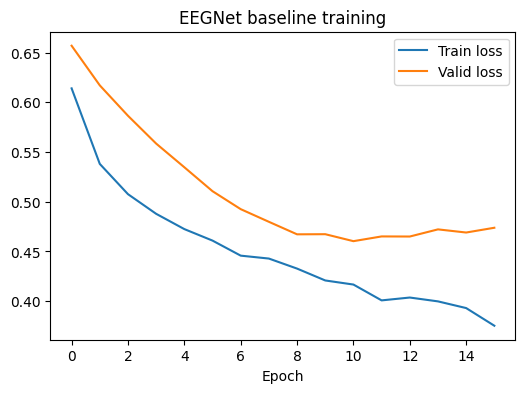

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6161       0.6894        0.6682  0.0005  0.2397
      2        0.5480       0.7234        0.6396  0.0005  0.2601
      3        0.5361       0.7319        0.6173  0.0005  0.2601
      4        0.5091       0.7404        0.5953  0.0005  0.2603
      5        0.4958       0.7574        0.5699  0.0005  0.2615
      6        0.4752       0.7489        0.5444  0.0005  0.2609
      7        0.4613       0.7489        0.5237  0.0005  0.2531
      8        0.4604       0.7404        0.5070  0.0005  0.2526
      9        0.4476       0.7404        0.4933  0.0005  0.2519
     10        0.4400       0.7362        0.4928  0.0005  0.2499
     11        0.4264       0.7404        0.4876  0.0005  0.2476
     12        0.4152       0.7404        0.4869  0.0005  0.2494
     13        0.4048       0.7532        0.4888  0.0005  0.2506
     14        0.3990    

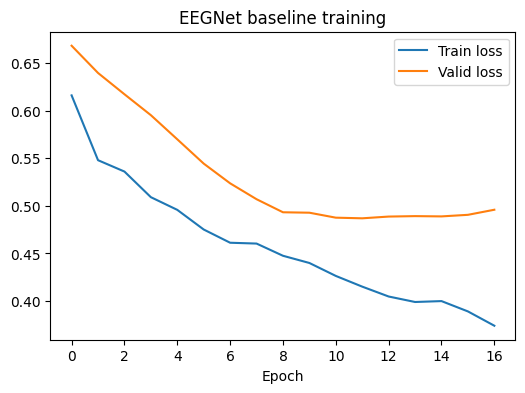

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6081       0.6894        0.6691  0.0005  0.2477
      2        0.5307       0.7021        0.6415  0.0005  0.2375
      3        0.5030       0.7149        0.6197  0.0005  0.2502
      4        0.4894       0.7191        0.5999  0.0005  0.2748
      5        0.4768       0.7362        0.5749  0.0005  0.2626
      6        0.4663       0.7362        0.5544  0.0005  0.2620
      7        0.4557       0.7447        0.5388  0.0005  0.2530
      8        0.4445       0.7404        0.5276  0.0005  0.2565
      9        0.4351       0.7447        0.5178  0.0005  0.2657
     10        0.4274       0.7447        0.5091  0.0005  0.2542
     11        0.4147       0.7277        0.5137  0.0005  0.2504
     12        0.4139       0.7404        0.5226  0.0005  0.2504
     13        0.3979       0.7404        0.5249  0.0005  0.2582
     14        0.4026    

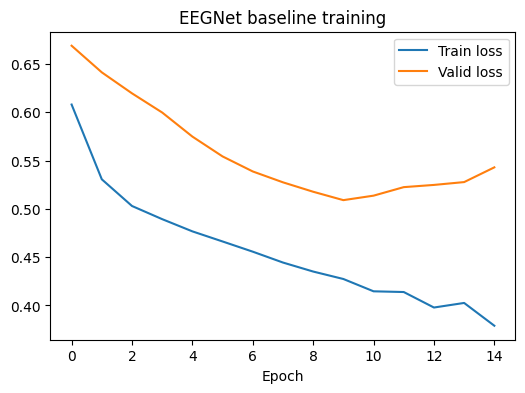

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6261       0.6468        0.6755  0.0005  0.2517
      2        0.5479       0.6766        0.6506  0.0005  0.2653
      3        0.5210       0.6766        0.6284  0.0005  0.2569
      4        0.5044       0.6936        0.6120  0.0005  0.2593
      5        0.4936       0.6979        0.5958  0.0005  0.2653
      6        0.4798       0.7064        0.5776  0.0005  0.2511
      7        0.4664       0.7064        0.5619  0.0005  0.2591
      8        0.4643       0.7234        0.5515  0.0005  0.2593
      9        0.4622       0.7234        0.5451  0.0005  0.2741
     10        0.4430       0.7234        0.5419  0.0005  0.2557
     11        0.4404       0.7064        0.5448  0.0005  0.2581
     12        0.4420       0.7191        0.5452  0.0005  0.2680
     13        0.4199       0.7191        0.5492  0.0005  0.2651
     14        0.4174    

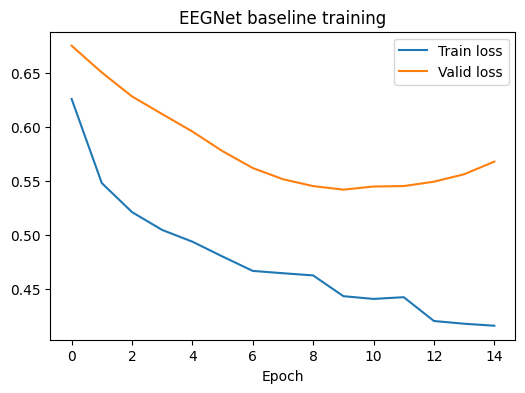

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6590       0.7277        0.6772  0.0005  0.2539
      2        0.5642       0.7447        0.6463  0.0005  0.2669
      3        0.5272       0.7447        0.6208  0.0005  0.2593
      4        0.5180       0.7277        0.6016  0.0005  0.2680
      5        0.4959       0.7191        0.5838  0.0005  0.2690
      6        0.4788       0.7319        0.5674  0.0005  0.2521
      7        0.4770       0.7277        0.5532  0.0005  0.2516
      8        0.4685       0.7319        0.5437  0.0005  0.2710
      9        0.4576       0.7234        0.5366  0.0005  0.2554
     10        0.4474       0.7277        0.5328  0.0005  0.2681
     11        0.4496       0.7149        0.5314  0.0005  0.2558
     12        0.4400       0.7106        0.5405  0.0005  0.2649
     13        0.4341       0.7106        0.5323  0.0005  0.2548
     14        0.4176    

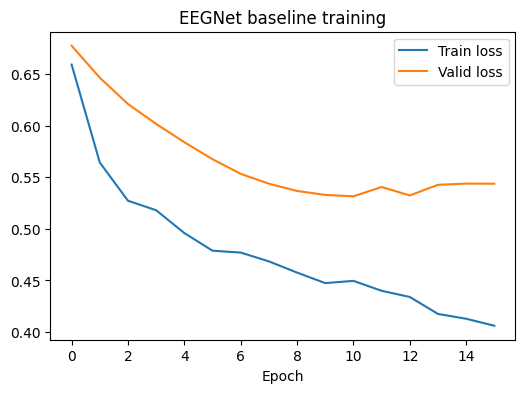

EEGNet + per-trial z-score     acc 0.742±0.042 | κ 0.482±0.084


In [38]:
baseline_acc_ztrial = eval_with_preproc(EpochData, 
                                        build_module=lambda: make_eegnet(EpochData = EpochData),
                                        preproc_pair_fn=zscore_per_trial_pair, 
                                        n_splits=5,
                                        plot_curves=True,
                                        filepath=FIGS)
summarize(baseline_acc_ztrial, "EEGNet + per-trial z-score")


In [39]:
baseline_acc_ztrial

[{'fold': 0, 'acc': 0.6938775510204082, 'kappa': 0.3877551020408163},
 {'fold': 1, 'acc': 0.6962457337883959, 'kappa': 0.3921020117956967},
 {'fold': 2, 'acc': 0.7406143344709898, 'kappa': 0.47876972051870226},
 {'fold': 3, 'acc': 0.7849829351535836, 'kappa': 0.5700910636513963},
 {'fold': 4, 'acc': 0.7918088737201365, 'kappa': 0.5835837934810466}]

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6398       0.6979        0.6694  0.0005  0.2749
      2        0.5634       0.7234        0.6382  0.0005  0.2536
      3        0.5292       0.7489        0.6061  0.0005  0.2494
      4        0.5136       0.7319        0.5807  0.0005  0.2633
      5        0.4916       0.7447        0.5567  0.0005  0.2560
      6        0.4736       0.7660        0.5310  0.0005  0.2514
      7        0.4660       0.7660        0.5107  0.0005  0.2636
      8        0.4555       0.7702        0.5002  0.0005  0.2677
      9        0.4421       0.7404        0.4936  0.0005  0.2679
     10        0.4387       0.7574        0.4876  0.0005  0.2626
     11        0.4222       0.7489        0.4883  0.0005  0.2503
     12        0.4279       0.7574        0.4846  0.0005  0.2667
     13        0.4126       0.7574        0.4937  0.0005  0.2539
     14        0.4155    

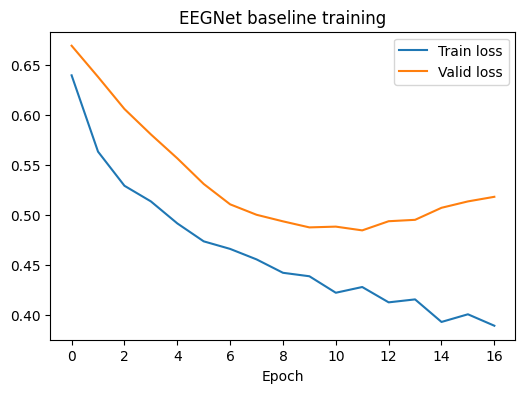

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6510       0.7106        0.6724  0.0005  0.2404
      2        0.5654       0.7149        0.6441  0.0005  0.2370
      3        0.5212       0.7319        0.6127  0.0005  0.2683
      4        0.4992       0.7319        0.5870  0.0005  0.2533
      5        0.4941       0.7447        0.5641  0.0005  0.2674
      6        0.4713       0.7362        0.5423  0.0005  0.2601
      7        0.4517       0.7404        0.5251  0.0005  0.2498
      8        0.4457       0.7277        0.5141  0.0005  0.2587
      9        0.4408       0.7319        0.5035  0.0005  0.2644
     10        0.4364       0.7319        0.4956  0.0005  0.2485
     11        0.4303       0.7489        0.4944  0.0005  0.2683
     12        0.4132       0.7574        0.4952  0.0005  0.2495
     13        0.4093       0.7489        0.4934  0.0005  0.2504
     14        0.4124    

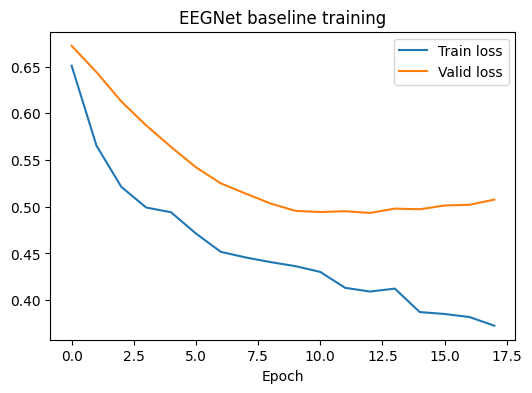

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6624       0.6638        0.6753  0.0005  0.2700
      2        0.5861       0.7064        0.6479  0.0005  0.2548
      3        0.5377       0.7106        0.6231  0.0005  0.2535
      4        0.5130       0.7064        0.6005  0.0005  0.2749
      5        0.4873       0.7234        0.5766  0.0005  0.2537
      6        0.4803       0.7234        0.5580  0.0005  0.2637
      7        0.4661       0.7447        0.5398  0.0005  0.2661
      8        0.4645       0.7447        0.5288  0.0005  0.2525
      9        0.4421       0.7447        0.5204  0.0005  0.2618
     10        0.4390       0.7447        0.5198  0.0005  0.2623
     11        0.4381       0.7319        0.5193  0.0005  0.2539
     12        0.4205       0.7489        0.5130  0.0005  0.2742
     13        0.4129       0.7489        0.5197  0.0005  0.2597
     14        0.4123    

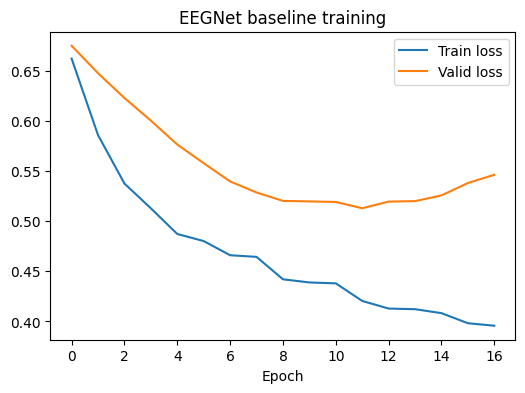

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6726       0.6638        0.6778  0.0005  0.2427
      2        0.5791       0.6723        0.6577  0.0005  0.2520
      3        0.5497       0.6936        0.6327  0.0005  0.2697
      4        0.5245       0.6936        0.6068  0.0005  0.2573
      5        0.4971       0.6979        0.5847  0.0005  0.2552
      6        0.4900       0.7021        0.5658  0.0005  0.2685
      7        0.4785       0.7106        0.5544  0.0005  0.2548
      8        0.4716       0.6936        0.5470  0.0005  0.2602
      9        0.4545       0.7064        0.5426  0.0005  0.2629
     10        0.4548       0.7021        0.5458  0.0005  0.2520
     11        0.4381       0.6936        0.5478  0.0005  0.2503
     12        0.4375       0.6894        0.5560  0.0005  0.2696
     13        0.4260       0.6936        0.5744  0.0005  0.2530
Stopping since valid_loss

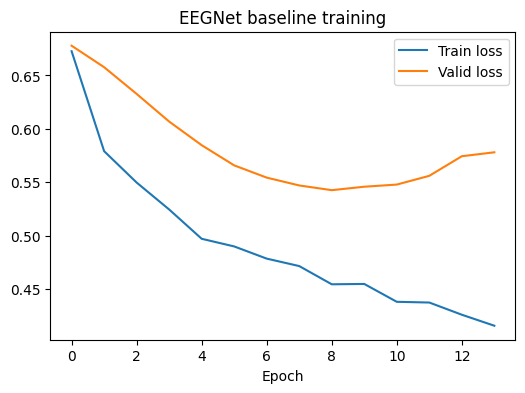

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6880       0.6723        0.6815  0.0005  0.2606
      2        0.6105       0.7362        0.6587  0.0005  0.2622
      3        0.5736       0.7319        0.6313  0.0005  0.2536
      4        0.5459       0.7319        0.6065  0.0005  0.2515
      5        0.5189       0.7362        0.5848  0.0005  0.2712
      6        0.5073       0.7191        0.5656  0.0005  0.2562
      7        0.4937       0.7191        0.5508  0.0005  0.2668
      8        0.4850       0.7234        0.5402  0.0005  0.2548
      9        0.4865       0.7106        0.5403  0.0005  0.2525
     10        0.4675       0.7106        0.5422  0.0005  0.2574
     11        0.4547       0.7064        0.5495  0.0005  0.2582
     12        0.4523       0.7064        0.5519  0.0005  0.2676
Stopping since valid_loss has not improved in the last 5 epochs.


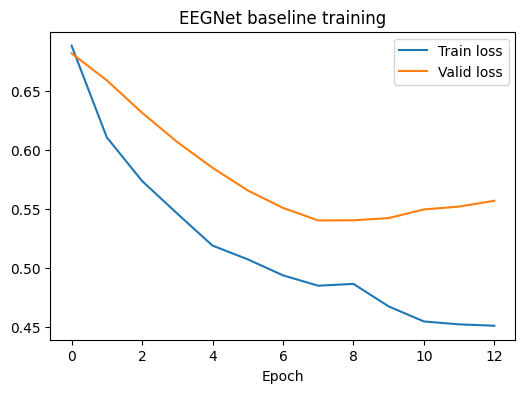

EEGNet + foldwise channel z-score acc 0.733±0.061 | κ 0.466±0.122


In [40]:
baseline_acc_foldstd = eval_with_preproc(EpochData, 
                                        build_module=lambda: make_eegnet(EpochData = EpochData),
                                        preproc_pair_fn=foldwise_channel_standardize_pair, 
                                        n_splits=5,
                                        plot_curves=True,
                                        filepath=FIGS)
summarize(baseline_acc_foldstd, "EEGNet + foldwise channel z-score")


In [41]:
baseline_acc_ztrial

[{'fold': 0, 'acc': 0.6938775510204082, 'kappa': 0.3877551020408163},
 {'fold': 1, 'acc': 0.6962457337883959, 'kappa': 0.3921020117956967},
 {'fold': 2, 'acc': 0.7406143344709898, 'kappa': 0.47876972051870226},
 {'fold': 3, 'acc': 0.7849829351535836, 'kappa': 0.5700910636513963},
 {'fold': 4, 'acc': 0.7918088737201365, 'kappa': 0.5835837934810466}]

In [42]:
baseline_acc_foldstd

[{'fold': 0, 'acc': 0.6598639455782312, 'kappa': 0.3197278911564626},
 {'fold': 1, 'acc': 0.6962457337883959, 'kappa': 0.3922436898408185},
 {'fold': 2, 'acc': 0.7098976109215017, 'kappa': 0.41667642581098485},
 {'fold': 3, 'acc': 0.7679180887372014, 'kappa': 0.5358740216175922},
 {'fold': 4, 'acc': 0.8327645051194539, 'kappa': 0.6654705594519654}]

### fine hyperparameter tuning

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6974       0.7362        0.6787  0.0005  0.2516
      2        0.6009       0.7830        0.6420  0.0005  0.2674
      3        0.5446       0.8085        0.5952  0.0005  0.2560
      4        0.5221       0.7957        0.5590  0.0005  0.2527
      5        0.4970       0.8043        0.5290  0.0005  0.2667
      6        0.4905       0.8085        0.5058  0.0005  0.2538
      7        0.4816       0.7957        0.4921  0.0005  0.2532
      8        0.4796       0.7915        0.4771  0.0005  0.2648
      9        0.4762       0.8043        0.4658  0.0005  0.2554
     10        0.4563       0.7787        0.4615  0.0005  0.2545
     11        0.4490       0.7872        0.4599  0.0005  0.2682
     12        0.4500       0.7915        0.4571  0.0005  0.2552
     13        0.4355       0.7957        0.4526  0.0005  0.2590
     14        0.4474    

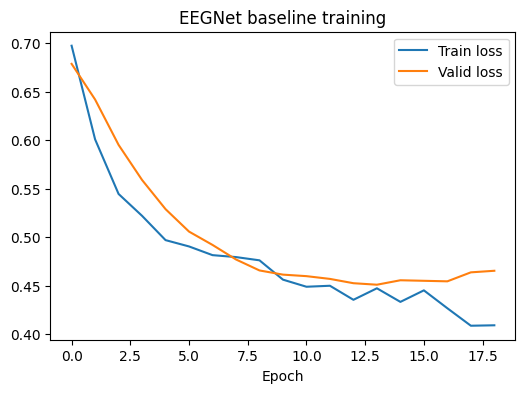

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6547       0.6979        0.6813  0.0005  0.2616
      2        0.5915       0.7319        0.6512  0.0005  0.2807
      3        0.5409       0.7489        0.6081  0.0005  0.2522
      4        0.5253       0.7660        0.5728  0.0005  0.2691
      5        0.5001       0.7489        0.5490  0.0005  0.2575
      6        0.4821       0.7574        0.5301  0.0005  0.2520
      7        0.4777       0.7532        0.5139  0.0005  0.2682
      8        0.4771       0.7617        0.5018  0.0005  0.2538
      9        0.4657       0.7532        0.4940  0.0005  0.2528
     10        0.4645       0.7574        0.4905  0.0005  0.2662
     11        0.4544       0.7489        0.4883  0.0005  0.2584
     12        0.4484       0.7617        0.4853  0.0005  0.2674
     13        0.4373       0.7489        0.4868  0.0005  0.2567
     14        0.4316    

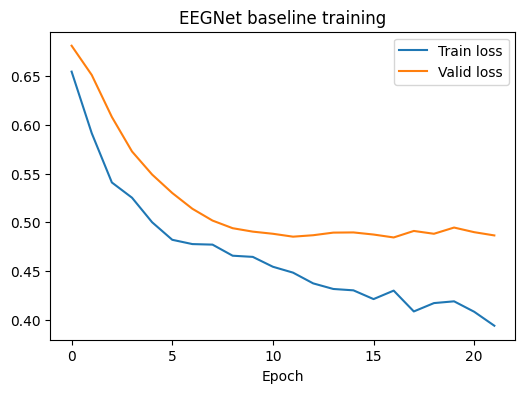

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6565       0.6596        0.6756  0.0005  0.2530
      2        0.5658       0.6979        0.6446  0.0005  0.2617
      3        0.5215       0.7106        0.6125  0.0005  0.2495
      4        0.5127       0.7191        0.5901  0.0005  0.2689
      5        0.5108       0.7234        0.5691  0.0005  0.2541
      6        0.4945       0.7319        0.5534  0.0005  0.2674
      7        0.4803       0.7489        0.5452  0.0005  0.2550
      8        0.4775       0.7191        0.5326  0.0005  0.2674
      9        0.4510       0.7447        0.5277  0.0005  0.2560
     10        0.4605       0.7447        0.5278  0.0005  0.2546
     11        0.4612       0.7447        0.5287  0.0005  0.2536
     12        0.4517       0.7277        0.5317  0.0005  0.2791
     13        0.4414       0.7319        0.5368  0.0005  0.2533
     14        0.4463    

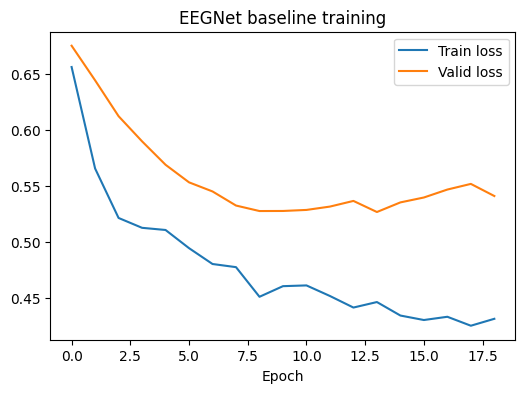

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6968       0.6383        0.6880  0.0005  0.2687
      2        0.6231       0.7106        0.6664  0.0005  0.2572
      3        0.5568       0.7064        0.6297  0.0005  0.2567
      4        0.5550       0.7149        0.6053  0.0005  0.2621
      5        0.5335       0.7149        0.5869  0.0005  0.2513
      6        0.5268       0.7149        0.5704  0.0005  0.2679
      7        0.5146       0.7021        0.5582  0.0005  0.2595
      8        0.5000       0.7106        0.5477  0.0005  0.2521
      9        0.4929       0.6936        0.5395  0.0005  0.2595
     10        0.4871       0.7277        0.5340  0.0005  0.2637
     11        0.4814       0.7149        0.5316  0.0005  0.2659
     12        0.4628       0.7064        0.5319  0.0005  0.2572
     13        0.4511       0.7191        0.5350  0.0005  0.2702
     14        0.4610    

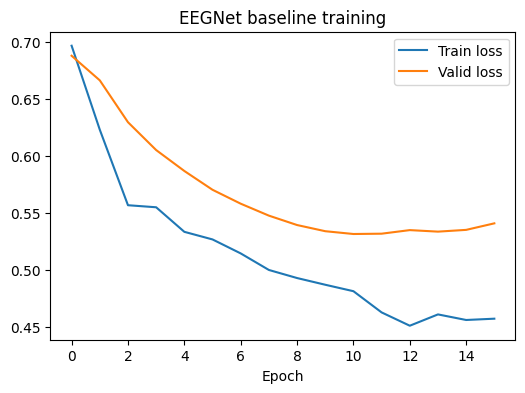

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.7077       0.5617        0.6903  0.0005  0.2494
      2        0.6510       0.6553        0.6774  0.0005  0.2700
      3        0.5863       0.7191        0.6440  0.0005  0.2526
      4        0.5539       0.7106        0.6114  0.0005  0.2532
      5        0.5297       0.7149        0.5912  0.0005  0.2535
      6        0.5289       0.7106        0.5745  0.0005  0.2722
      7        0.5108       0.7149        0.5593  0.0005  0.2663
      8        0.5069       0.7319        0.5504  0.0005  0.2528
      9        0.5056       0.7106        0.5465  0.0005  0.2694
     10        0.4961       0.7149        0.5409  0.0005  0.2542
     11        0.4808       0.7021        0.5451  0.0005  0.2524
     12        0.4889       0.7106        0.5456  0.0005  0.2642
     13        0.4674       0.7191        0.5470  0.0005  0.2552
     14        0.4724    

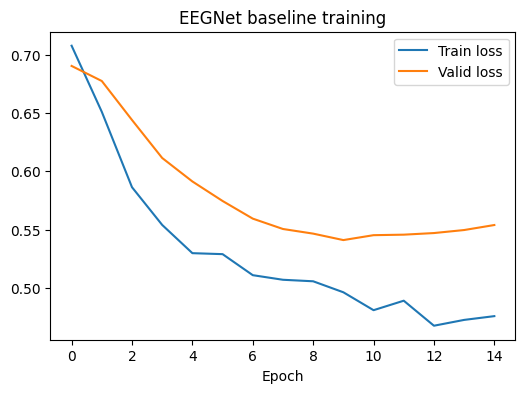

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6600       0.7745        0.6755  0.0005  0.5253
      2        0.5526       0.7745        0.6335  0.0005  0.4044
      3        0.5108       0.7745        0.5961  0.0005  0.4001
      4        0.4897       0.7830        0.5689  0.0005  0.4104
      5        0.4688       0.7745        0.5378  0.0005  0.4280
      6        0.4558       0.7787        0.5066  0.0005  0.4457
      7        0.4582       0.7702        0.4833  0.0005  0.4333
      8        0.4480       0.7872        0.4617  0.0005  0.4491
      9        0.4386       0.7915        0.4558  0.0005  0.4260
     10        0.4249       0.7915        0.4461  0.0005  0.4335
     11        0.4127       0.7745        0.4429  0.0005  0.4501
     12        0.3913       0.7702        0.4470  0.0005  0.4090
     13        0.3902       0.7787        0.4551  0.0005  0.3989
     14        0.4041    

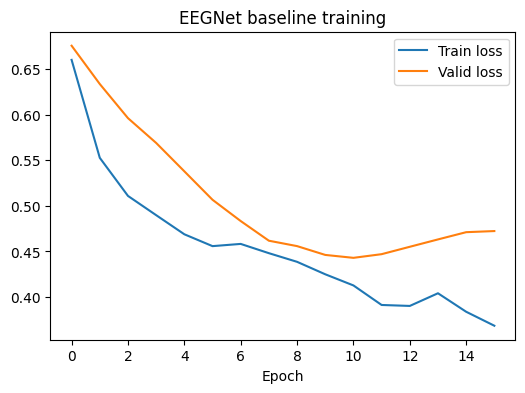

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6579       0.6553        0.6772  0.0005  0.4566
      2        0.5562       0.7617        0.6397  0.0005  0.4024
      3        0.5229       0.7574        0.6059  0.0005  0.4008
      4        0.5053       0.7787        0.5847  0.0005  0.4046
      5        0.4808       0.7702        0.5574  0.0005  0.4014
      6        0.4695       0.7617        0.5315  0.0005  0.3965
      7        0.4550       0.7574        0.5071  0.0005  0.3965
      8        0.4424       0.7404        0.4936  0.0005  0.4135
      9        0.4274       0.7447        0.4859  0.0005  0.4092
     10        0.4224       0.7574        0.4789  0.0005  0.3975
     11        0.4211       0.7617        0.4757  0.0005  0.4062
     12        0.4115       0.7745        0.4739  0.0005  0.3992
     13        0.3993       0.7745        0.4767  0.0005  0.3982
     14        0.3992    

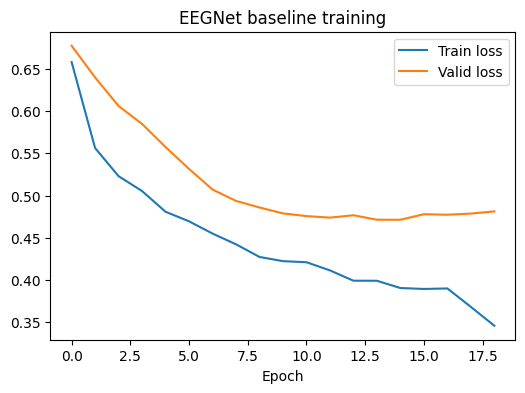

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6095       0.6809        0.6687  0.0005  0.4118
      2        0.5092       0.7149        0.6386  0.0005  0.3955
      3        0.4991       0.7234        0.6188  0.0005  0.3966
      4        0.4936       0.7106        0.6010  0.0005  0.3963
      5        0.4636       0.7191        0.5791  0.0005  0.3958
      6        0.4624       0.7277        0.5646  0.0005  0.4053
      7        0.4515       0.7319        0.5447  0.0005  0.3975
      8        0.4474       0.7277        0.5339  0.0005  0.3970
      9        0.4439       0.7319        0.5293  0.0005  0.3968
     10        0.4260       0.7319        0.5228  0.0005  0.3961
     11        0.4223       0.7277        0.5261  0.0005  0.3959
     12        0.4182       0.7362        0.5281  0.0005  0.3964
     13        0.4109       0.7277        0.5358  0.0005  0.4191
     14        0.4082    

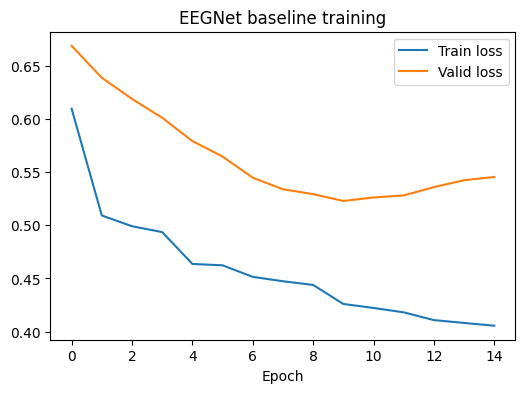

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6252       0.6511        0.6760  0.0005  0.3991
      2        0.5416       0.6766        0.6486  0.0005  0.3977
      3        0.5252       0.7064        0.6282  0.0005  0.3988
      4        0.5072       0.7362        0.6081  0.0005  0.3995
      5        0.4801       0.7319        0.5859  0.0005  0.4046
      6        0.4826       0.7489        0.5660  0.0005  0.3982
      7        0.4704       0.7277        0.5534  0.0005  0.3973
      8        0.4512       0.7234        0.5403  0.0005  0.3985
      9        0.4426       0.7149        0.5306  0.0005  0.3973
     10        0.4519       0.7191        0.5279  0.0005  0.3977
     11        0.4289       0.7234        0.5321  0.0005  0.4011
     12        0.4215       0.7106        0.5337  0.0005  0.4033
     13        0.4119       0.7149        0.5345  0.0005  0.3973
     14        0.4275    

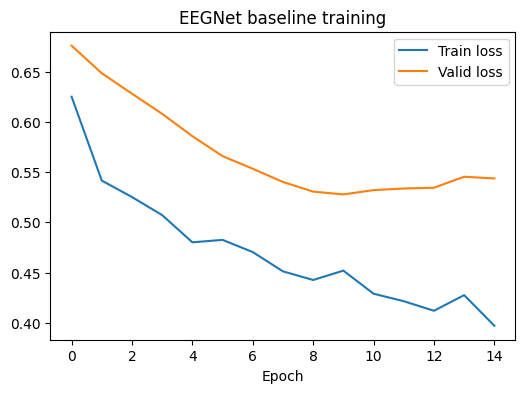

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6930       0.6851        0.6790  0.0005  0.3986
      2        0.5968       0.7149        0.6502  0.0005  0.3988
      3        0.5579       0.7277        0.6257  0.0005  0.4054
      4        0.5380       0.7362        0.6068  0.0005  0.3996
      5        0.5259       0.7447        0.5893  0.0005  0.3984
      6        0.5046       0.7660        0.5704  0.0005  0.3974
      7        0.5092       0.7574        0.5522  0.0005  0.4338
      8        0.4799       0.7489        0.5351  0.0005  0.3985
      9        0.4742       0.7489        0.5245  0.0005  0.3978
     10        0.4712       0.7617        0.5193  0.0005  0.4067
     11        0.4688       0.7574        0.5154  0.0005  0.3975
     12        0.4428       0.7447        0.5085  0.0005  0.3973
     13        0.4470       0.7447        0.5151  0.0005  0.3960
     14        0.4382    

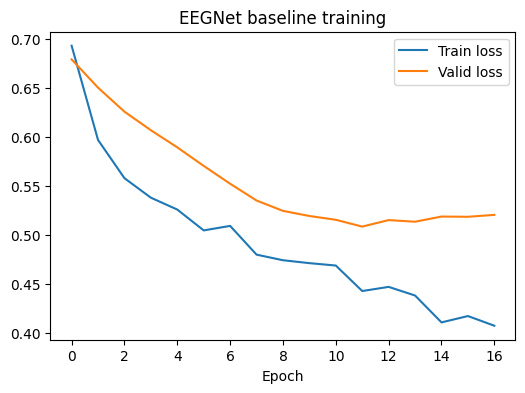

,F1,D,drop,acc_mean,acc_std,kappa_mean,kappa_std
0,8,2,0.5,0.74152,0.042674,0.482371,0.085426
1,16,2,0.5,0.73266,0.055221,0.464687,0.110445


Best (coarse): {'F1': 8.0, 'D': 2.0, 'drop': 0.5, 'acc_mean': 0.7415198161175732, 'acc_std': 0.04267422247495646, 'kappa_mean': 0.4823708529098713, 'kappa_std': 0.08542592387337246}


In [43]:
import numpy as np
import pandas as pd
from itertools import product

grid = {
    "F1":        [8, 16],
    "D":         [2],#[2, 4],
    "drop":     [0.5]#[0.25, 0.5],
}

results = []
for F1, D, drop in product(*grid.values()):
    rows = eval_with_preproc(
        EpochData,
        build_module=lambda: make_eegnet(EpochData = EpochData, F1=F1, D=D, drop=drop),
        preproc_pair_fn=zscore_per_trial_pair,
        n_splits=5,
        plot_curves=True,
        filepath=FIGS
    )
    accs   = [r["acc"] for r in rows]
    kappas = [r["kappa"] for r in rows]
    results.append({
        "F1": F1, "D": D, "drop": drop,
        "acc_mean": np.mean(accs), "acc_std": np.std(accs),
        "kappa_mean": np.mean(kappas), "kappa_std": np.std(kappas),
    })

tune_df = pd.DataFrame(results).sort_values("acc_mean", ascending=False).reset_index(drop=True)
display(tune_df.head(10))  # top configs
best = tune_df.iloc[0].to_dict()
print("Best (coarse):", best)


In [44]:
# 'F1': 8.0, 'D': 2.0, 'drop': 0.5, 'epochs': 30.0, 'batch': 32.0, 'acc_mean': 0.7517633674630262, 'acc_std': 0.05274310656010483, 'kappa_mean': 0.5029765838789825, 'kappa_std': 0.10538937939036418}

In [45]:
best

{'F1': 8.0,
 'D': 2.0,
 'drop': 0.5,
 'acc_mean': 0.7415198161175732,
 'acc_std': 0.04267422247495646,
 'kappa_mean': 0.4823708529098713,
 'kappa_std': 0.08542592387337246}

In [46]:
# best_rows = eval_with_preproc(
#     X, y, subjects,
#     build_module=lambda: make_eegnet(F1=int(best["F1"]), D=int(best["D"]), drop=float(best["drop"])),
#     preproc_pair_fn=zscore_per_trial_pair,
#     n_splits=5,
#     plot_curves=True,
#     saveFigs=True,
#     filepath=FIGS
# )
# summarize(best_rows, "EEGNet (best params) + per-trial z-score")


In [47]:
from sklearn.metrics import accuracy_score, cohen_kappa_score
from src.utils_io import makeEEGclassifier
import numpy as np
import pandas as pd

def loso_final_eval(EpochData: EpochDataset, build_module, preproc_pair_fn, label="EEGNet LOSO"):
    """
    Leave-One-Subject-Out evaluation.
    EpochData : EpochDataset
    build_module : function that returns a fresh EEG model
    preproc_pair_fn : function(X_train, X_test) -> (X_train_p, X_test_p)
    """
    X, y, subjects = EpochData.X, EpochData.y, EpochData.subjects
    classes_ = np.unique(y)
    unique_subs = np.unique(subjects)
    rows = []
    y_all_true, y_all_pred = [], []

    for sub in unique_subs:
        print(f"\n🧠 Testing on subject {sub}...")
        tr_idx = np.where(subjects != sub)[0]
        te_idx = np.where(subjects == sub)[0]

        Xtr, Xte = X[tr_idx], X[te_idx]
        ytr, yte = y[tr_idx], y[te_idx]

        # preprocessing (safe: uses only train stats)
        Xtr_p, Xte_p = preproc_pair_fn(Xtr, Xte)

        # build and train
        clf = makeEEGclassifier(build_module(), classes_)
        clf.fit(Xtr_p, ytr)

        # predict on test subject
        yhat = clf.predict(Xte_p)
        acc = accuracy_score(yte, yhat)
        kappa = cohen_kappa_score(yte, yhat)

        rows.append(dict(sub=sub, acc=acc, kappa=kappa, n_test=len(yte)))
        print(f"   acc={acc:.3f}, κ={kappa:.3f}")

        # collect for global CM
        y_all_true.append(yte)
        y_all_pred.append(yhat)

    df = pd.DataFrame(rows)
    y_all_true = np.concatenate(y_all_true)
    y_all_pred = np.concatenate(y_all_pred)
    print(f"\n{label}: acc {df.acc.mean():.3f}±{df.acc.std():.3f} | κ {df.kappa.mean():.3f}±{df.kappa.std():.3f}")
    return df, y_all_true, y_all_pred, clf 


In [48]:
# Final hold-out per subject (LOSO)
df_loso, y_loso_true, y_loso_pred = loso_final_eval(
    EpochData,
    build_module=lambda: make_eegnet(EpochData,F1=8, D=2, drop=0.25),
    preproc_pair_fn=zscore_per_trial_pair,
    label="EEGNet + per-trial z-score (LOSO final test)"
)



🧠 Testing on subject 1...
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6421       0.6655        0.6707  0.0005  0.3083
      2        0.5386       0.7099        0.6274  0.0005  0.3147
      3        0.5051       0.7372        0.5952  0.0005  0.3115
      4        0.4909       0.7338        0.5702  0.0005  0.3306
      5        0.4800       0.7372        0.5449  0.0005  0.3239
      6        0.4738       0.7270        0.5283  0.0005  0.3183
      7        0.4607       0.7304        0.5165  0.0005  0.3168
      8        0.4568       0.7372        0.5114  0.0005  0.3174
      9        0.4515       0.7372        0.5120  0.0005  0.3175
     10        0.4491       0.7235        0.5129  0.0005  0.3271
     11        0.4330       0.7167        0.5154  0.0005  0.3152
     12        0.4194       0.7201        0.5193  0.0005  0.3147
Stopping since valid_loss has not improved in the last 5 epochs

/opt/homebrew/Caskroom/miniforge/base/envs/neurodecode/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6116       0.6966        0.6592  0.0005  0.9653
      2        0.5243       0.7103        0.6207  0.0005  0.3160
      3        0.5046       0.7310        0.5939  0.0005  0.3236
      4        0.4958       0.7345        0.5695  0.0005  0.3178
      5        0.4862       0.7310        0.5494  0.0005  0.3152
      6        0.4737       0.7310        0.5319  0.0005  0.3104
      7        0.4596       0.7345        0.5218  0.0005  0.3121
      8        0.4535       0.7310        0.5167  0.0005  0.3146
      9        0.4507       0.7310        0.5157  0.0005  0.3129
     10        0.4383       0.7345        0.5159  0.0005  0.3097
     11        0.4364       0.7448        0.5150  0.0005  0.3127
     12        0.4333       0.7517        0.5187  0.0005  0.3261
     13        0.4212       0.7586        0.5217  0.0005  0.3129
     14        0.4152    

/opt/homebrew/Caskroom/miniforge/base/envs/neurodecode/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6259       0.7614        0.6606  0.0005  0.3101
      2        0.5645       0.7649        0.6268  0.0005  0.3069
      3        0.5365       0.7684        0.5988  0.0005  0.3065
      4        0.5186       0.7719        0.5640  0.0005  0.3039
      5        0.5092       0.7579        0.5346  0.0005  0.3026
      6        0.4928       0.7579        0.5049  0.0005  0.3136
      7        0.4795       0.7579        0.4814  0.0005  0.3067
      8        0.4751       0.7719        0.4675  0.0005  0.3073
      9        0.4642       0.7719        0.4612  0.0005  0.3063
     10        0.4545       0.7719        0.4601  0.0005  0.3079
     11        0.4526       0.7754        0.4574  0.0005  0.3169
     12        0.4391       0.7895        0.4588  0.0005  0.3472
     13        0.4500       0.7860        0.4607  0.0005  0.3092
     14        0.4218    

/opt/homebrew/Caskroom/miniforge/base/envs/neurodecode/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6555       0.6807        0.6764  0.0005  0.3137
      2        0.5665       0.7298        0.6362  0.0005  0.3053
      3        0.5200       0.7579        0.6031  0.0005  0.3044
      4        0.5057       0.7579        0.5766  0.0005  0.3030
      5        0.4915       0.7439        0.5493  0.0005  0.3061
      6        0.4762       0.7684        0.5216  0.0005  0.3107
      7        0.4674       0.7649        0.5043  0.0005  0.3046
      8        0.4603       0.7719        0.4905  0.0005  0.3053
      9        0.4524       0.7789        0.4909  0.0005  0.3062
     10        0.4511       0.7649        0.4860  0.0005  0.3051
     11        0.4393       0.7789        0.4866  0.0005  0.3070
     12        0.4342       0.7789        0.4873  0.0005  0.3020
     13        0.4223       0.7684        0.4874  0.0005  0.3041
     14        0.4264    

/opt/homebrew/Caskroom/miniforge/base/envs/neurodecode/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5915       0.7123        0.6643  0.0005  0.3202
      2        0.5145       0.7158        0.6296  0.0005  0.3132
      3        0.4877       0.7192        0.6023  0.0005  0.3122
      4        0.4720       0.7226        0.5741  0.0005  0.3181
      5        0.4595       0.7089        0.5509  0.0005  0.3143
      6        0.4497       0.7226        0.5345  0.0005  0.3178
      7        0.4390       0.7192        0.5239  0.0005  0.3185
      8        0.4282       0.7260        0.5243  0.0005  0.3171
      9        0.4221       0.7363        0.5267  0.0005  0.3156
     10        0.4107       0.7192        0.5283  0.0005  0.3150
     11        0.4049       0.7123        0.5332  0.0005  0.3159
Stopping since valid_loss has not improved in the last 5 epochs.
   acc=1.000, κ=1.000

🧠 Testing on subject 72...
  epoch    train_loss    valid_acc    va

/opt/homebrew/Caskroom/miniforge/base/envs/neurodecode/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5988       0.7228        0.6623  0.0005  0.3938
      2        0.5239       0.7404        0.6343  0.0005  0.4072
      3        0.5007       0.7404        0.6135  0.0005  0.5555
      4        0.4894       0.7298        0.5918  0.0005  0.4534
      5        0.4786       0.7333        0.5662  0.0005  0.3914
      6        0.4654       0.7368        0.5476  0.0005  0.5394
      7        0.4599       0.7368        0.5352  0.0005  0.5394
      8        0.4385       0.7298        0.5286  0.0005  0.3156
      9        0.4344       0.7298        0.5275  0.0005  0.3100
     10        0.4234       0.7368        0.5258  0.0005  0.3135
     11        0.4150       0.7368        0.5323  0.0005  0.3066
     12        0.4107       0.7298        0.5372  0.0005  0.3056
     13        0.4039       0.7298        0.5404  0.0005  0.3050
     14        0.3893    

ValueError: too many values to unpack (expected 3)

In [49]:
df_loso

,sub,acc,kappa,n_test
0,1,1.000000,1.000000,4
1,2,0.821429,0.639175,28
2,3,1.000000,NaN,2
3,6,0.705882,0.397163,17
4,7,1.000000,1.000000,18
5,8,0.764706,0.529412,34
6,11,0.707317,0.412888,41
7,12,0.666667,0.400000,3
8,14,0.560000,0.110032,25
9,16,0.629630,0.224138,27


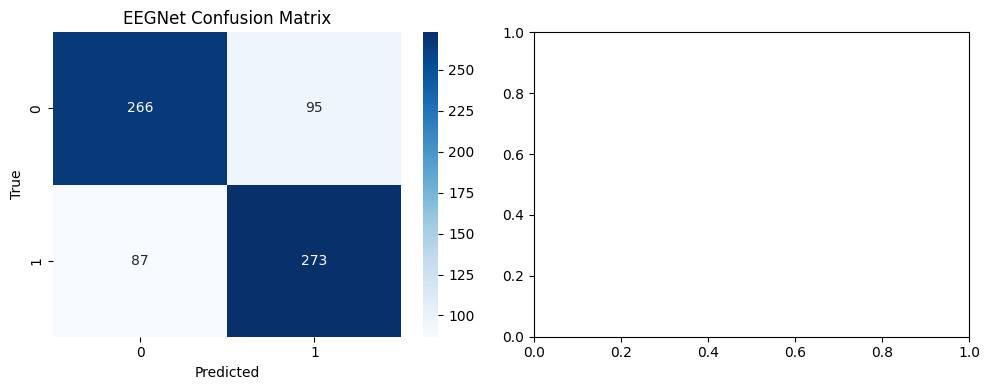

In [50]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm_eegnet = confusion_matrix(y_loso_true, y_loso_pred)
# cm_shallow = confusion_matrix(y, y_pred_shallow)
f, ax = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(cm_eegnet, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('EEGNet Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
# sns.heatmap(cm_shallow, annot=True, fmt='d', ax=ax[1], cmap='Greens')
# ax[1].set_title('ShallowFBCSPNet Confusion Matrix')
# ax[1].set_xlabel('Predicted')
# ax[1].set_ylabel('True')
plt.tight_layout()
plt.show()#savefig(FIGS / "confusion_matrices.png", dpi=300)   

In [51]:
# Visualize learned temporal kernel of EEGNet
import matplotlib.pyplot as plt
weights = clf.module_.conv_temporal.weight.detach().cpu().numpy()[0]
plt.plot(weights[0]); plt.title("Temporal kernel – EEGNet"); plt.tight_layout()
# plt.savefig("../figs/day7_eegnet_kernel.png",dpi=150)
plt.show()


NameError: name 'clf' is not defined